#Feature Ranking Methods

## 1. Rank using FLDR

Using the MNIST dataset, I ranked the features using Fisher’s Linear Discriminant Ratio as 
the criteria

### Import Libraries

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
import unittest
from sklearn.feature_selection import f_classif

### Load and split the data

In [22]:
train_df = pd.read_csv('mnist_train.csv')
test_df = pd.read_csv('mnist_test.csv')

In [23]:
train_df.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to 28x28
dtypes: int64(785)
memory usage: 359.3 MB


We have 60000 instances and 785 features representing the pixels. The labels are 0 to 9 representing the digits

In [25]:
X_train = train_df.iloc[:,1:] ## The features are from the second column to the end
y_train = train_df.iloc[:,0] ## The labels are in the first column
X_test = test_df.iloc[:,1:]
y_test = test_df.iloc[:,0]

### Define the function to calculate FLDR:


In [26]:
def fldr(X, y, feature_idx, class1, class2,  epsilon=1e-9):
    """
    Calculate Fisher's Linear Discriminant Ratio (FLDR) for a given feature index.

    FLDR is a measure used in feature selection to evaluate the separability of two classes
    based on a specific feature.

    Parameters:
    - X (pd.DataFrame): Input data matrix with features.
    - y (np.ndarray): Target labels.
    - feature_idx (int): Index of the feature column to compute FLDR for.
    - class1 (int): Label of the first class.
    - class2 (int): Label of the second class.
    - epsilon (float): small value to avoid dividing by zero

    Returns:
    - fldr_value (float): The computed FLDR value for the given feature index.
    """
    # Extract data for the two classes
    class1_data = X[y == class1].iloc[:, feature_idx].values
    class2_data = X[y == class2].iloc[:, feature_idx].values
    # Calculate means and variance
    mean1 = np.mean(class1_data)
    mean2 = np.mean(class2_data)
    # Add epsilon to variance to avoid division by zero
    variance = np.var(np.concatenate((class1_data, class2_data))) + epsilon
    # Calculate between-class scatter
    between_scatter = (mean1 - mean2)**2
    # Calculate FLDR
    fldr_value = between_scatter / variance
    return fldr_value


### Create function for FLDR Ranking

In [27]:
def compute_fldr_ranking(X, y):
    """
    Compute feature ranking based on Fisher's Linear Discriminant Ratio (FLDR) values.

    FLDR is a measure used in feature selection to evaluate the separability of classes
    based on each feature.

    Parameters:
    - X (pd.DataFrame): Input data matrix with features.
    - y (np.ndarray): Target labels.

    Returns:
    - feature_ranking (np.ndarray): Array containing the indices of features ranked by FLDR values.
    """
    num_features = X.shape[1]  # Number of features
    num_classes = len(np.unique(y))  # Number of unique classes
    
    # Initialize DataFrame to store FLDR values
    fdr_df = pd.DataFrame(index=range(num_features), columns=[f'Class Pair: {i} vs {j}' for i in range(num_classes) for j in range(i+1, num_classes)])

    # Convert X and y to numpy arrays
    X_np = np.array(X)
    y_np = np.array(y)

    # Compute FLDR for each feature and class pair
    for feature_idx in range(num_features):
        for class1 in range(num_classes):
            for class2 in range(class1+1, num_classes):
                # Compute FLDR using optimized fldr function
                fldr_val = fldr(X, y, feature_idx, class1, class2)
                # Store FLDR value in the DataFrame
                fdr_df.at[feature_idx, f'Class Pair: {class1} vs {class2}'] = fldr_val

    # Rank features based on average FLDR values
    fdr_avg = fdr_df.mean(axis=1)  # Compute the average FLDR value across each feature
    feature_ranking = fdr_avg.sort_values(ascending=False).index  # Sort features based on FLDR values in descending order

    # Print feature ranking and corresponding FLDR values
    for rank, feature_idx in enumerate(feature_ranking):  # Iterate over the ranked features
        print(f"Rank {rank + 1}: Feature {feature_idx}, FLDR = {fdr_avg[feature_idx]}")  # Print feature ranking and FLDR value


    return feature_ranking


### Rank the features using Fisher’s Linear Discriminant Ratio as the criteria 

In [28]:
train_feature_ranking = compute_fldr_ranking(X_train, y_train)

Rank 1: Feature 378, FLDR = 0.9744153509180636
Rank 2: Feature 406, FLDR = 0.9077237428089079
Rank 3: Feature 350, FLDR = 0.8762054351307198
Rank 4: Feature 461, FLDR = 0.8716105279452451
Rank 5: Feature 434, FLDR = 0.8702893898646757
Rank 6: Feature 409, FLDR = 0.8259624285360319
Rank 7: Feature 433, FLDR = 0.8258106753761332
Rank 8: Feature 462, FLDR = 0.8028244562652418
Rank 9: Feature 489, FLDR = 0.7950496190378868
Rank 10: Feature 377, FLDR = 0.7851655305414688
Rank 11: Feature 405, FLDR = 0.7764292259344046
Rank 12: Feature 542, FLDR = 0.7736943913512191
Rank 13: Feature 568, FLDR = 0.7663204554807829
Rank 14: Feature 437, FLDR = 0.7634763487612573
Rank 15: Feature 569, FLDR = 0.7631580164805162
Rank 16: Feature 597, FLDR = 0.7615448935863223
Rank 17: Feature 436, FLDR = 0.7504520289537262
Rank 18: Feature 596, FLDR = 0.7502362248348724
Rank 19: Feature 373, FLDR = 0.7365015287370132
Rank 20: Feature 401, FLDR = 0.7361858947151048
Rank 21: Feature 381, FLDR = 0.7350228660641167
R

## 2 Decision Tree Classifier

## 2.1 Fit a decision tree classifier

In [29]:
def fit_decision_tree(X, y, random_state=42):
    """
    Fits a decision tree classifier to the given dataset.

    Parameters:
        X (array-like): Features of the dataset.
        y (array-like): Labels of the dataset.
        random_state (int or None): Random seed for reproducibility.

    Returns:
        trained_model: Trained decision tree classifier.
    """
    # Initialize and fit the decision tree classifier
    clf = DecisionTreeClassifier(random_state=random_state)
    clf.fit(X, y)
    return clf

trained_model = fit_decision_tree(X_train, y_train)

## 2.b cross validation

In [52]:
def k_fold_cross_validation(data, k, random_state=42):
    """
    Perform k-fold cross-validation on the given dataset.

    Parameters:
    - data (List): The dataset to be split into folds.
    - k (int): The number of folds for cross-validation.
    - random_state (int): Random seed for reproducibility. Default is 42.

    Returns:
    - folds (List[Tuple[List[int], List[int]]]): A list of tuples representing the training and testing indices for each fold.
    """
    # Set random seed for reproducibility
    np.random.seed(random_state)
    
    # Convert data to numpy array and shuffle
    data=np.array(data)
    np.random.shuffle(data)
    
    # Calculate the size of each fold
    fold_size = len(data) // k
    
    # Initialize list to store fold indices
    folds = []
    
    # Generate training and testing indices for each fold
    for i in range(k):
        # Calculate the starting and ending indices for the current fold
        start_index = i * fold_size
        end_index = min((i + 1) * fold_size, len(data))
        
        # Create a list of indices for the testing data in the current fold
        testing_indices = list(range(start_index, end_index))
        
        # Create a list of indices for the training data in the current fold
        # by excluding the testing indices
        training_indices = [idx for idx in range(len(data)) if idx not in testing_indices]
        
        # Append a tuple containing the training and testing indices
        # for the current fold to the folds list
        folds.append((training_indices, testing_indices))
    return folds

In [53]:
def cross_validate_decision_tree(data, k=5, random_state=42):
    
    """
    Perform k-fold cross-validation on the given dataset using decision tree.

    Parameters:
    - data (List): The dataset to be split into folds and trained on.
    - k (int): The number of folds for cross-validation.
    - random_state (int): Random seed for reproducibility. Default is 42.

    Returns:
    - average_accuracy: The average accuracy over all folds.
    """
    # Set random seed for reproducibility
    np.random.seed(random_state)
    
    # Convert data to numpy array
    data = np.array(data)
    
    # Call the K-fold cross validation function to get the folds
    folds = k_fold_cross_validation(data, k, random_state)
    
    # Initialize list to store the accuracies
    accuracies = []
    for fold in folds:
        train_indices, test_indices = fold
        X_train = data[train_indices, 1:]  # Features for training
        y_train = data[train_indices, 0]   # Labels for training
        X_test = data[test_indices, 1:]    # Features for testing
        y_test = data[test_indices, 0]     # Labels for testing
        
        # Initialize and fit the decision tree classifier
        trained_model = fit_decision_tree(X_train, y_train, random_state)
        
        # Predict on the testing set and compute accuracy
        y_pred = trained_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(accuracy)
        accuracies.append(accuracy) # Append to the accuracies list
        
    # Compute average accuracy
    average_accuracy = np.mean(accuracies)
    return average_accuracy


In [54]:
average_accuracy= cross_validate_decision_tree(train_df, k=5)

# Print the scores
print("Cross-validation score :", average_accuracy)

0.8716666666666667
0.86075
0.8621666666666666
0.861
0.8741666666666666
Cross-validation score : 0.86595


It seems like the model performs consistently well across different folds, with the average score being approximately 0.866, indicating that the model generalizes reasonably well to unseen data.

## 2.c Extract the feature importances

In [55]:
# Initialize and fit the decision tree classifier
trained_model = fit_decision_tree(X_train, y_train)

# Predict on the testing set and compute accuracy
y_pred = trained_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy: ", accuracy)

Model Accuracy:  0.8759


We can also see that the decision tree scores 0.8755 on the whole test dataset when trained on the whole training datasets. This confirms that the model generalizes well as it is very close to the cross validation score

In [56]:
feature_importances = trained_model.feature_importances_
# Print or use the feature importances as needed
print("Feature importances:", feature_importances)

Feature importances: [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.

### 2.d Unit Testing

In [74]:
class FeatureRanker:
    def __init__(self, X,y):
        """
        Initializes the FeatureRanker object.

        Parameters:
        - X (DataFrame): The feature matrix.
        - y (Series): The target variable.

        Returns:
        - None
        """
        self.X = X
        self.y = y
    def rank_features(self):
        """
        Ranks the features based on their importance using ANOVA F-test.

        Returns:
        - ranked_features (Series): Series containing feature names ranked by importance.
        """
        feature_scores = {}
        # Perform ANOVA test
        f_scores, p_values = f_classif(self.X, self.y)

        # Pair F-scores and p-values with feature names
        anova_results = pd.DataFrame({'Feature': X.columns, 'F-score': f_scores, 'p-value': p_values})

        # Sort features based on F-scores in descending order
        ranked_features = anova_results.sort_values(by='F-score', ascending=False)['Feature']
        return ranked_features

In [89]:
#Calling in the function to rank features. 
iris_data = pd.read_csv("iris.csv")
# Separate features and target variable
X = iris_data.drop(columns=['species'])
y = iris_data['species']

# Initialize the FeatureRanker with the data
ranker = FeatureRanker( X, y)

# Rank the features
ranked_features = ranker.rank_features()
ranked_features

2    petal_length
3     petal_width
0    sepal_length
1     sepal_width
Name: Feature, dtype: object

I used the ANOVA statistical test to compare between the variance across the means and sort the features based on the F-score. 
Note that we already know what are the most important features and their ranking for the iris dataset. We see that ANOVA gave us the same ranking we are expecting, that is why we will used in the unit testing

In [93]:
class TestFeatureRanking(unittest.TestCase):
    def setUp(self):
        # Test on Iris dataset
        self.random_state = 42
        iris_data = pd.read_csv("iris.csv")
        label_encoder = LabelEncoder()
        iris_data['species'] = label_encoder.fit_transform(iris_data['species'])
        self.y = iris_data['species']
        self.X = iris_data[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]
        ranker = FeatureRanker(self.X, self.y)
        self.expected_ranking = ranker.rank_features()

    def test_fldr_feature_ranking(self):
        # Compute expected rankings based on feature importance
        expected_ranking_names = self.expected_ranking.tolist()

        # Compute rankings using FLDR method
        fldr_ranking = np.array(compute_fldr_ranking(self.X, self.y))
        fldr_ranking_names = self.X.columns[fldr_ranking].tolist()

        # Assert that the rankings are consistent
        self.assertListEqual(expected_ranking_names, fldr_ranking_names)

    def test_decision_tree_feature_ranking(self):
        # Initialize and fit the decision tree classifier
        trained_model = fit_decision_tree(X=self.X, y=self.y, random_state=42)
        feature_importances = trained_model.feature_importances_

        # Get feature names
        feature_names = self.X.columns

        # Sort indices in descending order of feature importance
        dt_ranking = np.argsort(feature_importances)[::-1]
        dt_ranking_names = feature_names[dt_ranking].tolist()

        # Assert that the rankings are consistent
        self.assertListEqual(self.expected_ranking.tolist(), dt_ranking_names)

In [ ]:
# Load test cases
loader = unittest.TestLoader().loadTestsFromTestCase(TestFeatureRanking)
unittest.TextTestRunner().run(loader)

While the decision tree's feature importance correctly identified the most significant features, FLDR ranked the first and second features differently. However, it's noteworthy that the FLDR scores are quite similar. This discrepancy may converge on a larger dataset, indicating that FLDR's performance could improve with more data.

### 2.e Plot

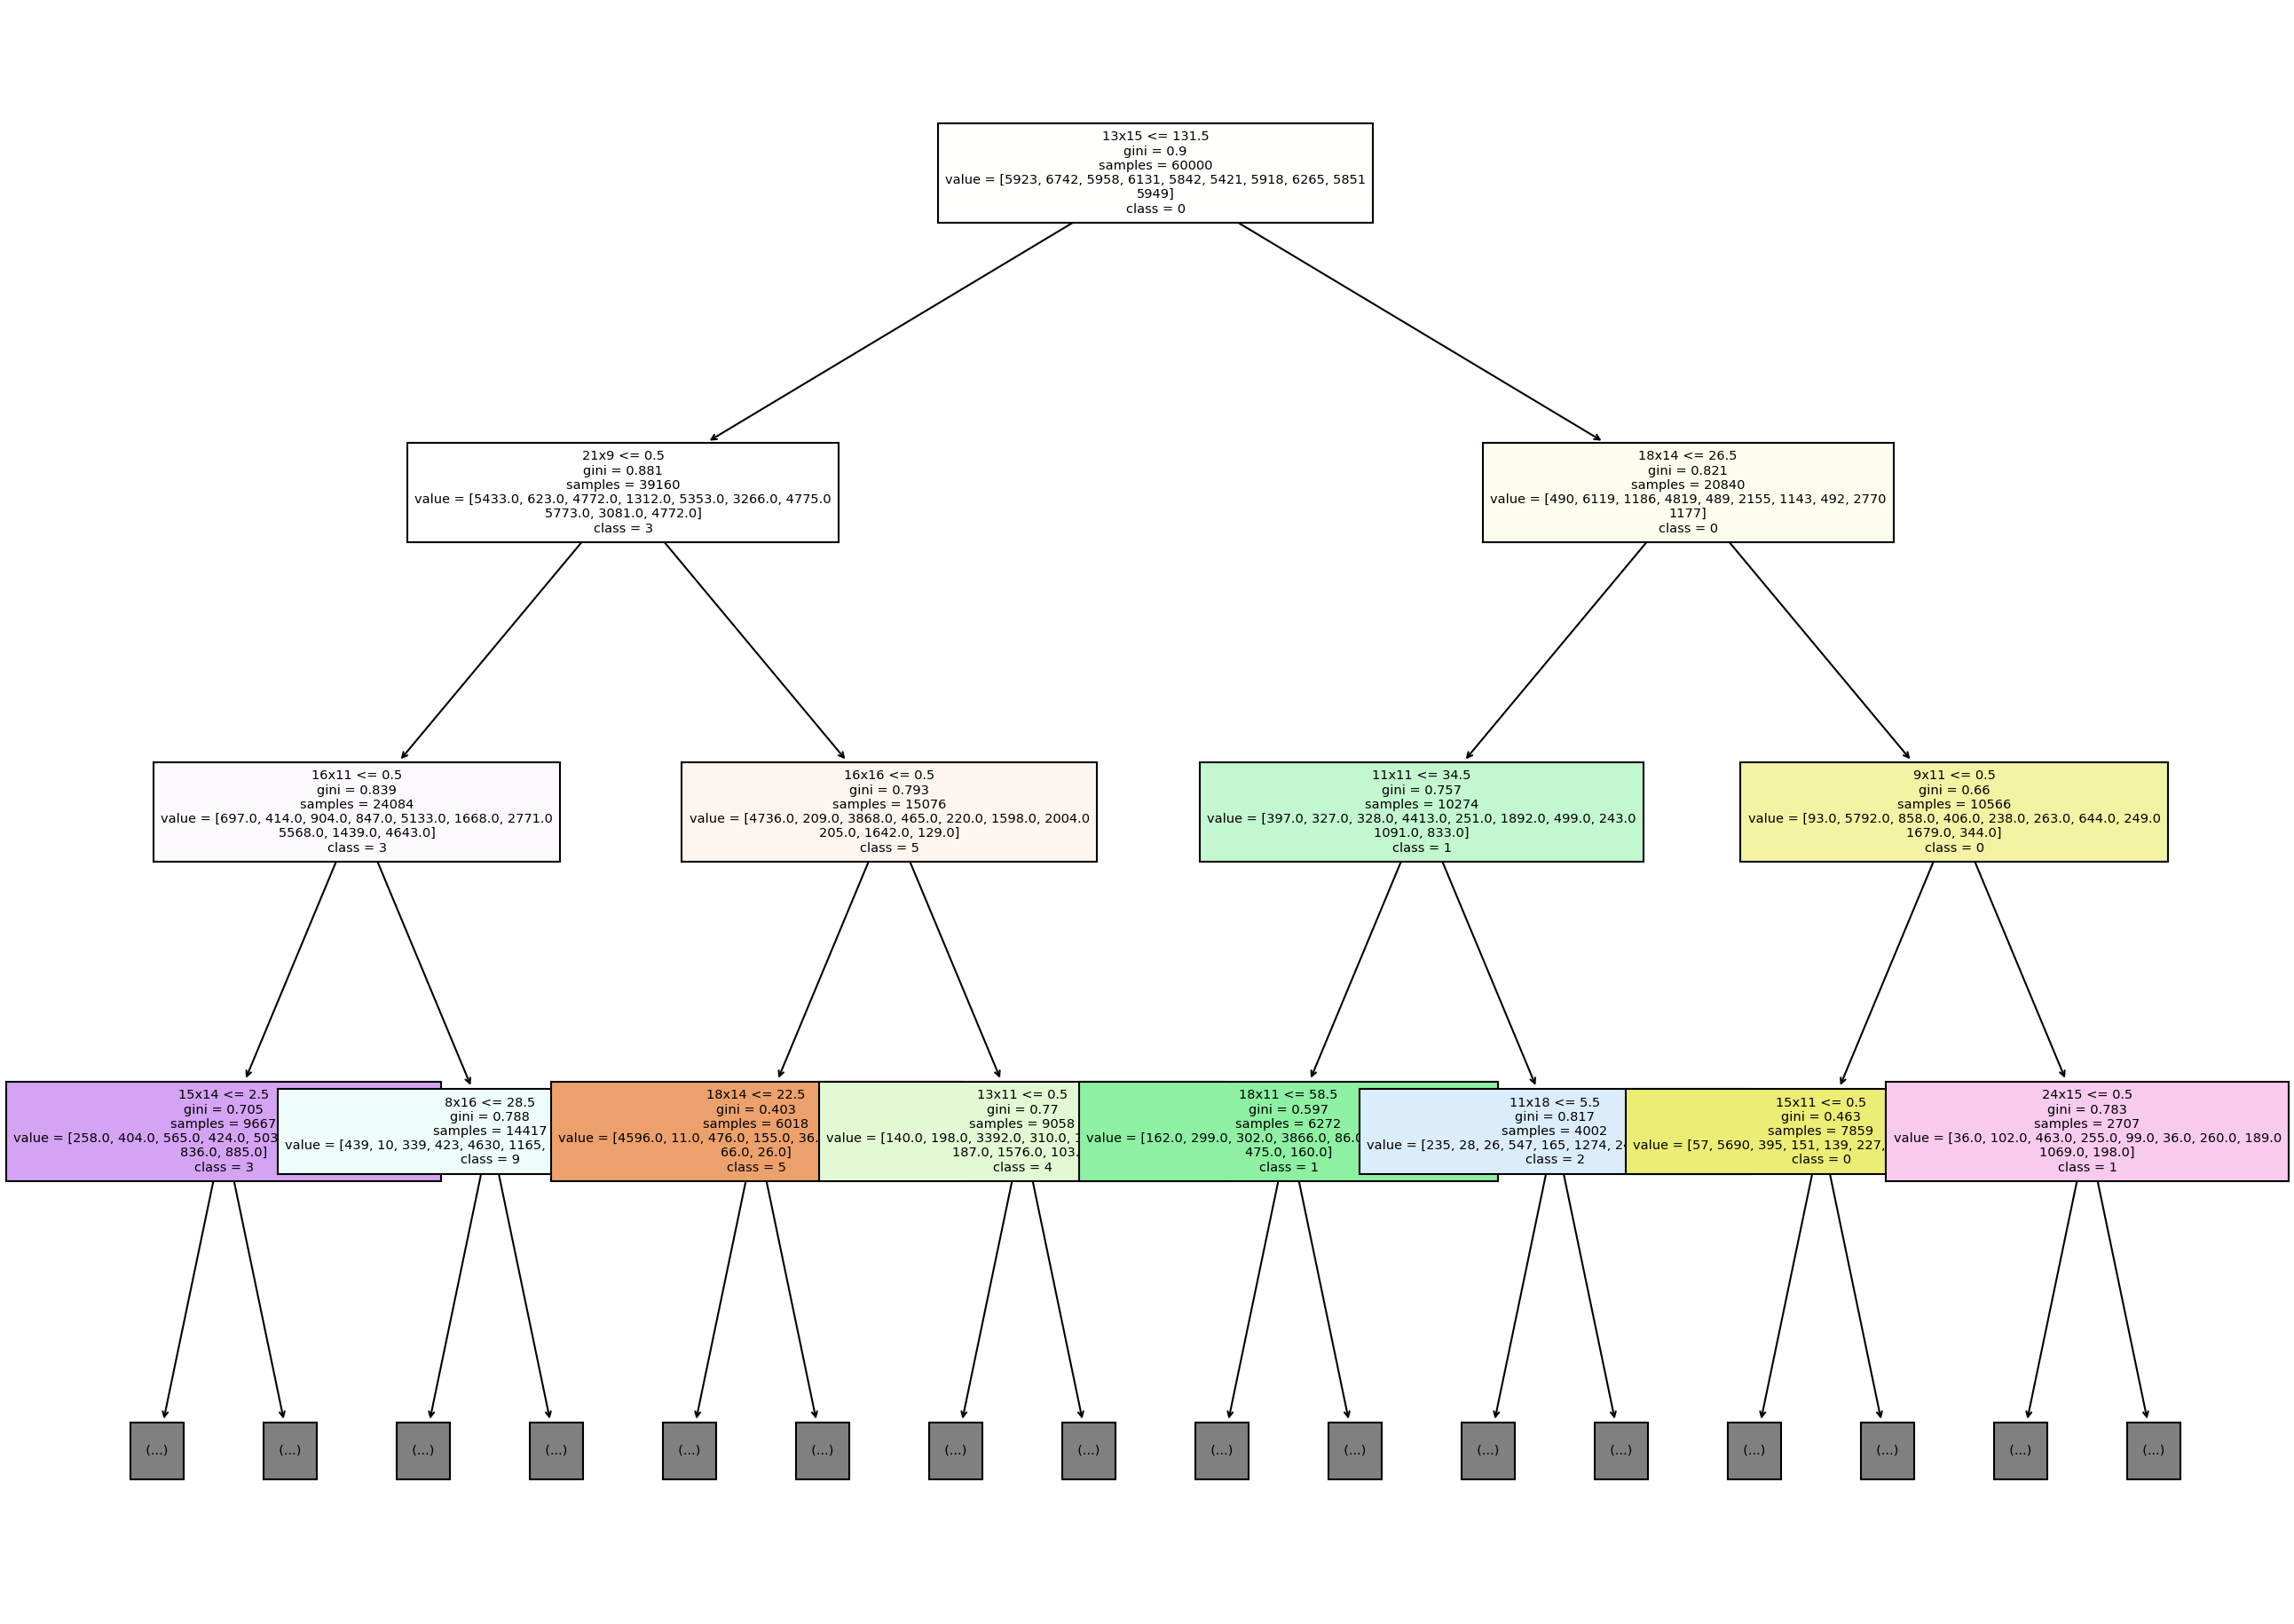

In [97]:
# Set figure size and DPI for better quality
plt.figure(figsize=(20, 15), dpi=150)

class_names = np.array(train_df.iloc[:,0]).astype('str').tolist() 
y = train_df.iloc[:,0]
X =  train_df.iloc[:,1:]
# Plot decision tree
plot_tree(trained_model, filled=True, feature_names=list(X.columns), class_names=list(class_names), max_depth=3,
         fontsize = 7)
# Adjust plot margins for better visualization
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

plt.show()

### 2.e Analysis of Plot


---

To examine the key parameters, let's explore the function header from sklearn:

```python
sklearn.tree.plot_tree(decision_tree, *, max_depth=None, feature_names=None, class_names=None, label='all', filled=False, impurity=True, node_ids=False, proportion=False, rounded=False, precision=3, ax=None, fontsize=None)
```

We set the following parameters:

- `max_depth = 3`
- `feature_names = list(X.columns)`
- `class_names = list(class_names)`
- `filled = True`
- `fontsize = 7`

Explanation of selected parameters:
- **`max_depth`**: Specifies the maximum depth of the decision tree.
- **`feature_names`**: Provides the names of features (columns).
- **`class_names`**: Supplies the names of classes.
- **`filled`**: Determines whether to paint the majority class in each node.
- **`fontsize`**: Controls the font size to enhance readability.

Other parameters are left with default values. For instance, `label='all'` means we want informative labels for impurity at each node, and `impurity=True` means we want to show impurity at each node.

When we examine the plot displayed, we can observe several key pieces of information at each node:

- **Node Split Criteria**: Indicates the feature and threshold value used for splitting the data at that node. For example, at the root, the feature was 13x15 with the value being less than or equal 131.5
- **Gini Impurity**: Decision tree uses Gini Impurity -or Entropy if we want- to evaluate the homogeneity of classes within each node. For example, at the root we have a gini index of 0.9 , as we go deeper, it is expected that the value will decrease as the uncertainty decreases. 
- **Samples**: The number of instances in the dataset that reach that particular node during the training process. For example, in the first level, The left node had 39160 examples while the right node had 20840 examples. If we add the examples at each level, they should add up to the total number of instances we have in the dataset.
- **Value**: Shows the class distribution of samples at each node. For classification -like the MNIST dataset-, it shows the count of samples for each class at that node. Again, if we add the arrays at each level, they should add up to the total count of samples for each class overall.
- **Class**: Predicted class based on the majority class.

Regarding the predict method:
- Decision trees traverse the tree from the root node to a leaf node based on feature values.
- At each internal node, the feature value of the input instance is compared with the threshold value stored in the node.
- The process continues until a leaf node is reached, and the predicted class at the leaf node is returned.

For runtime complexity:
- We have two computations in training a decision tree, tree construction, and using all the features. For the first computation, At each node, we try to find the best split based on a feature. To do so, we need to sort the values, which takes $O(n \log n)$ . For the second computation, We need to consider all the features m. Therefore, in total, the runtime complexity is $O(m \cdot n \log n)$. Where $m$ is the number of features and $n$ is the number of instances.
- Prediction complexity is $O(\log n)$ as the tree is traversed from root to leaf.

--- 


### 2.e Feature Importance Comparison

While both the decision tree and the Fisher's Linear Discriminant Ratio are used for deciding the most important features, they work very differently under the hood.

The differences are as follows:
1. Method:
      - **Decision Tree:** The most important features are decided by calculating the features that decreases the uncertainty the most. If we look at the tree plot, we can see that these are the ones at the top of the tree. This is done by either calculating the Gini Index or the Entropy before and after the split.
      - **FLDR:** The most important features are the ones that have the highest FLDR value. This value is calculated by the discriminant ratio for each feature, measuring how well it discriminates between different classes in the dataset.
      

2. Benefits:

      - **Decision Tree:** 
          - Simple to interpret and anyone can understand by just looking at the graph. 
          - No assumptions or preprocessing is needed to fit the Decision Tree and hence getting the most important features. 
          - Fast to compute and it is done automatically while fitting the decision tree.
      - **FLDR:** 
          - Less susceptible to high cardinality features.
          - Takes feature interactions into consideration.
          - Ranking is independent of the model and can be applied to various algorithms.      

3. Limitations:

      - **Decision Tree:** 
          - Biased Towards Features with Many Categories.
          - Doesn't handle correlated features as well as FLDR.
          - Importance is relative to the specific tree structure, which can vary with random seeds.
      - **FLDR:** 
          - Computationally expensive specially for large datasets.     
          - Not easily interpretable.
          - Assumes data follows multivariate normal distribution within each class, which can be not true.
          - Requires preprocessing, specially for outliers, as it is highly sensitive to outliers.
          - Requires balanced data as it can be biased towards the class that have the largest number of instances.
